<a href="https://colab.research.google.com/github/jimwhite/commentator_ai/blob/main/Transcript_to_Video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [109]:
%pip install -q stability-sdk youtube-transcript-api langchain openai

In [110]:
#@title Set up Google Drive for file storage
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    outputs_path = "/content/gdrive/MyDrive/Commentator_AI/Transcript_to_Video"
    !mkdir -p $outputs_path
except:
    outputs_path = "."
print(f"Files will be saved to {outputs_path}")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Files will be saved to /content/gdrive/MyDrive/Commentator_AI/Transcript_to_Video


In [111]:
#@title Set YouTube URL
import re
def ytIdFromURL(url:str)->str:
   data = re.findall(r"(?:v=|\/)([0-9A-Za-z_-]{11}).*", url)
   if data:
       return data[0]
   return None

YOUTUBE_URL = "https://www.youtube.com/watch?v=vPKp29Luryc" #@param {type:"string"}
video_id = ytIdFromURL(YOUTUBE_URL)
print(f'YouTube video ID = {video_id}')

YouTube video ID = vPKp29Luryc


In [112]:
#@title Get Video Transcript (CSV)

# Using CSV files is a convenient way to integrate with LangChain (and LangFlow).
# Also is much more efficient in token usage so longer transcripts will work for
# any given LLM context token limit.

import csv
import os
from youtube_transcript_api import YouTubeTranscriptApi

if not video_id:
  raise ValueError("video_id isn't set")

transcript = []
out_dir = os.path.join(outputs_path, video_id)
transcript_file_path = os.path.join(out_dir, 'transcript.csv')
fieldnames = ['start', 'duration', 'text']
if os.path.exists(transcript_file_path):
  with open(transcript_file_path, 'r') as csv_file:
    reader = csv.DictReader(csv_file, fieldnames=fieldnames, quoting=csv.QUOTE_NONNUMERIC)
    next(reader)  # skip header
    for row in reader:
      transcript.append(row)
    print(f'Read transcript from file: {transcript_file_path}')

if not transcript:
  transcript = YouTubeTranscriptApi.get_transcript(video_id)
  print('Got transcript from YouTube API')
  os.makedirs(out_dir, exist_ok=True)
  with open(transcript_file_path, 'w', newline='') as csv_file:
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames, quoting=csv.QUOTE_NONNUMERIC)
    writer.writeheader()
    for row in transcript:
      writer.writerow(row)
    print(f'Saved transcript to file: {transcript_file_path}')

transcript

Read transcript from file: /content/gdrive/MyDrive/Commentator_AI/Transcript_to_Video/vPKp29Luryc/transcript.csv


[{'start': 7.407, 'duration': 4.071, 'text': 'O say can you see,'},
 {'start': 11.478, 'duration': 3.737, 'text': "by the dawn's early light,"},
 {'start': 15.215, 'duration': 3.837, 'text': 'What so proudly we hailed'},
 {'start': 19.052,
  'duration': 3.937,
  'text': "at the twilight's last gleaming?"},
 {'start': 22.989,
  'duration': 3.937,
  'text': 'Whose broad stripes and bright stars,'},
 {'start': 26.926, 'duration': 3.537, 'text': 'through the perilous fight,'},
 {'start': 30.463, 'duration': 3.737, 'text': "O'er the ramparts we watched,"},
 {'start': 34.2, 'duration': 4.071, 'text': 'were so gallantly streaming?'},
 {'start': 38.271, 'duration': 3.837, 'text': 'And the rockets red glare,'},
 {'start': 42.108, 'duration': 3.837, 'text': 'the bombs bursting in air,'},
 {'start': 45.945, 'duration': 3.737, 'text': 'Gave proof through the night'},
 {'start': 49.682,
  'duration': 3.871,
  'text': 'that our flag was still there.'},
 {'start': 53.553, 'duration': 2.603, 'text': '

In [113]:
transcript_csv_text = ''
with open(transcript_file_path, 'r') as csv_file:
  transcript_csv_text = csv_file.read()

transcript_csv_text

'"start","duration","text"\n7.407,4.071,"O say can you see,"\n11.478,3.737,"by the dawn\'s early light,"\n15.215,3.837,"What so proudly we hailed"\n19.052,3.937,"at the twilight\'s last gleaming?"\n22.989,3.937,"Whose broad stripes and bright stars,"\n26.926,3.537,"through the perilous fight,"\n30.463,3.737,"O\'er the ramparts we watched,"\n34.2,4.071,"were so gallantly streaming?"\n38.271,3.837,"And the rockets red glare,"\n42.108,3.837,"the bombs bursting in air,"\n45.945,3.737,"Gave proof through the night"\n49.682,3.871,"that our flag was still there."\n53.553,2.603,"O say does that"\n56.156,6.573,"star spangled banner yet wave"\n62.729,4.871,"O\'er the land of the free,"\n67.6,7.608,"and the home of the brave."\n'

In [114]:
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage, SystemMessage

image_description_csv_text = None
out_dir = os.path.join(outputs_path, video_id)
image_description_file_path = os.path.join(out_dir, 'image_descriptions.csv')
fieldnames = ['start', 'duration', 'text', 'description']
if os.path.exists(image_description_file_path):
  with open(image_description_file_path, 'r') as csv_file:
    image_description_csv_text = csv_file.read()
    print(f'Read image descriptions from file: {image_description_file_path}')

if not image_description_csv_text:
  chat = ChatOpenAI(temperature=0.3, model=CHAT_MODEL)
  print('ChatGPT working...')
  response = chat([HumanMessage(content=f"""You're a visual musical artist.
  Given the following lyrics choose the phrases that should be illustrated to make a timed music video for this song.
  Respond in CSV format with the columns 'start', 'duration', 'text' (for the transcription text), 'description' (for the image description).
  Keep in mind that each image description will be rendered separately so don't use any references between them.
  Also because the image rendering is done in isolation for each description please be sure to include
  enough thematic keys in them so the images are holistic related to the song's theme.

  {transcript_csv_text}""")])
  print('Got image descriptions from ChatGPT')
  image_description_csv_text = response.content
  print(image_description_csv_text)
  os.makedirs(out_dir, exist_ok=True)
  with open(image_description_file_path, 'w', newline='') as csv_file:
    csv_file.write(response.content)
    print(f'Saved image descriptions to file: {image_description_file_path}')

image_description_csv_text

ChatGPT working...
Got image descriptions from ChatGPT
"start","duration","text","description"
7.407,4.071,"O say can you see,","A person looking out into the distance, with a questioning expression on their face."
11.478,3.737,"by the dawn's early light,","A beautiful sunrise, with the first rays of light breaking through the darkness."
15.215,3.837,"What so proudly we hailed","A group of people cheering and waving with pride."
19.052,3.937,"at the twilight's last gleaming?","A twilight sky, with the last gleam of sunlight disappearing."
22.989,3.937,"Whose broad stripes and bright stars,","A close-up of the American flag, focusing on the stripes and stars."
26.926,3.537,"through the perilous fight,","A depiction of a fierce battle, with soldiers fighting bravely."
30.463,3.737,"O'er the ramparts we watched,","People watching from the ramparts of a fortress, with a sense of anticipation."
34.2,4.071,"were so gallantly streaming?","The American flag streaming gallantly in the wind."
38

'"start","duration","text","description"\n7.407,4.071,"O say can you see,","A person looking out into the distance, with a questioning expression on their face."\n11.478,3.737,"by the dawn\'s early light,","A beautiful sunrise, with the first rays of light breaking through the darkness."\n15.215,3.837,"What so proudly we hailed","A group of people cheering and waving with pride."\n19.052,3.937,"at the twilight\'s last gleaming?","A twilight sky, with the last gleam of sunlight disappearing."\n22.989,3.937,"Whose broad stripes and bright stars,","A close-up of the American flag, focusing on the stripes and stars."\n26.926,3.537,"through the perilous fight,","A depiction of a fierce battle, with soldiers fighting bravely."\n30.463,3.737,"O\'er the ramparts we watched,","People watching from the ramparts of a fortress, with a sense of anticipation."\n34.2,4.071,"were so gallantly streaming?","The American flag streaming gallantly in the wind."\n38.271,3.837,"And the rockets red glare,","R

In [115]:
#@title Connect to the Stability API
import io
import os
import warnings

from IPython.display import display
from PIL import Image
from stability_sdk import client
import stability_sdk.interfaces.gooseai.generation.generation_pb2 as generation

if not 'STABILITY_KEY' in os.environ:
  key = getpass('Enter your Stability API key: ')
  if key:
    os.environ['STABILITY_KEY'] = key

stability_api = client.StabilityInference(
    key=os.environ['STABILITY_KEY'],
    verbose=True,
)


INFO:stability_sdk.client:Opening channel to grpc.stability.ai:443
INFO:stability_sdk.client:Channel opened to grpc.stability.ai:443


In [116]:
def generate_image(prompt: str):
  # the object returned is a python generator
  answers = stability_api.generate(
      prompt=prompt,
      seed=34567, # if provided, specifying a random seed makes results deterministic
      steps=20, # defaults to 30 if not specified
  )

  # iterating over the generator produces the api response
  for resp in answers:
      for artifact in resp.artifacts:
          if artifact.finish_reason == generation.FILTER:
              warnings.warn(
                  "Your request activated the API's safety filters and could not be processed."
                  "Please modify the prompt and try again.")
          if artifact.type == generation.ARTIFACT_IMAGE:
              img = Image.open(io.BytesIO(artifact.binary))
              return img

  print(f"No image for '{prompt}'")
  return None

INFO:stability_sdk.client:Sending request.


{'start': 7.407, 'duration': 4.071, 'text': 'O say can you see,', 'description': 'A person looking out into the distance, with a questioning expression on their face.'}
Generating image for A person looking out into the distance, with a questioning expression on their face.


INFO:stability_sdk.client:Got answer 1d210923-170f-41b3-92ba-13353ea90ced with artifact types ['ARTIFACT_IMAGE', 'ARTIFACT_CLASSIFICATIONS', 'ARTIFACT_LATENT'] in 5.69s


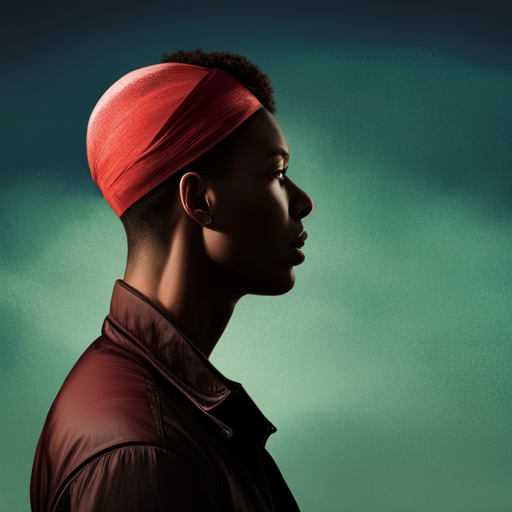

INFO:stability_sdk.client:Sending request.


{'start': 11.478, 'duration': 3.737, 'text': "by the dawn's early light,", 'description': 'A beautiful sunrise, with the first rays of light breaking through the darkness.'}
Generating image for A beautiful sunrise, with the first rays of light breaking through the darkness.


INFO:stability_sdk.client:Got answer dc8c9b0e-7ec8-407c-b916-012ddcd90845 with artifact types ['ARTIFACT_IMAGE', 'ARTIFACT_CLASSIFICATIONS', 'ARTIFACT_LATENT'] in 2.55s


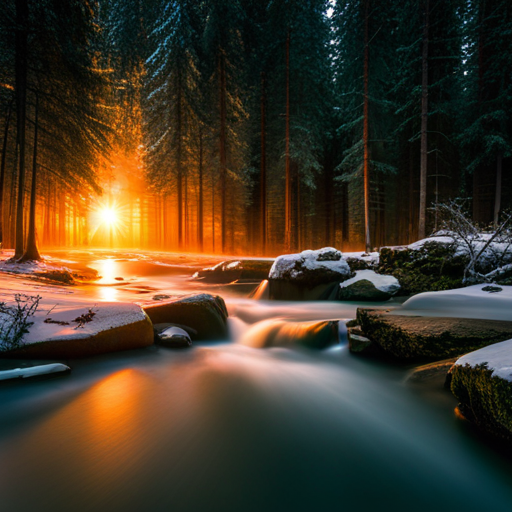

INFO:stability_sdk.client:Sending request.


{'start': 15.215, 'duration': 3.837, 'text': 'What so proudly we hailed', 'description': 'A group of people cheering and waving with pride.'}
Generating image for A group of people cheering and waving with pride.


INFO:stability_sdk.client:Got answer bf798eaf-d929-467a-bb5e-8a72989cd4ab with artifact types ['ARTIFACT_IMAGE', 'ARTIFACT_CLASSIFICATIONS', 'ARTIFACT_LATENT'] in 2.93s


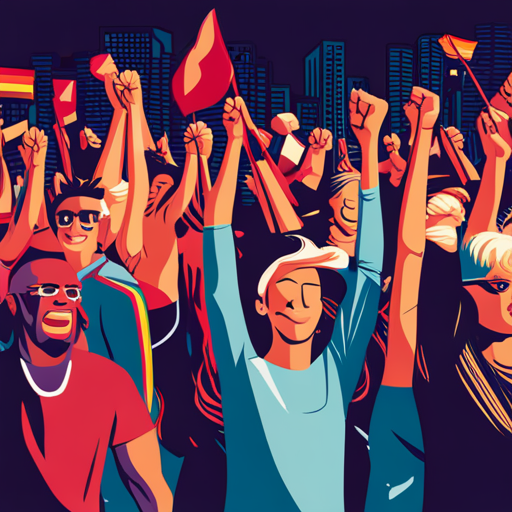

INFO:stability_sdk.client:Sending request.


{'start': 19.052, 'duration': 3.937, 'text': "at the twilight's last gleaming?", 'description': 'A twilight sky, with the last gleam of sunlight disappearing.'}
Generating image for A twilight sky, with the last gleam of sunlight disappearing.


INFO:stability_sdk.client:Got answer 633abe07-7394-4b6c-9a47-81d9148bae43 with artifact types ['ARTIFACT_IMAGE', 'ARTIFACT_CLASSIFICATIONS', 'ARTIFACT_LATENT'] in 2.71s


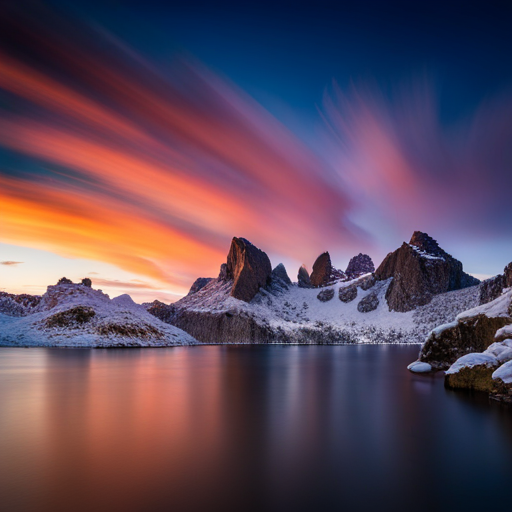

INFO:stability_sdk.client:Sending request.


{'start': 22.989, 'duration': 3.937, 'text': 'Whose broad stripes and bright stars,', 'description': 'A close-up of the American flag, focusing on the stripes and stars.'}
Generating image for A close-up of the American flag, focusing on the stripes and stars.


INFO:stability_sdk.client:Got answer cfbff1cb-47d3-4b05-b25f-6709991a93c5 with artifact types ['ARTIFACT_IMAGE', 'ARTIFACT_CLASSIFICATIONS', 'ARTIFACT_LATENT'] in 3.61s


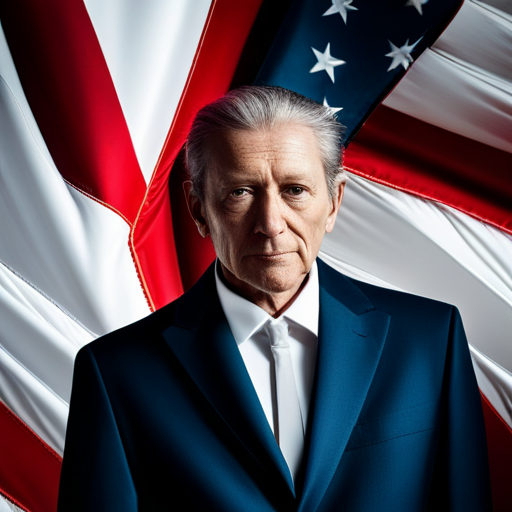

INFO:stability_sdk.client:Sending request.


{'start': 26.926, 'duration': 3.537, 'text': 'through the perilous fight,', 'description': 'A depiction of a fierce battle, with soldiers fighting bravely.'}
Generating image for A depiction of a fierce battle, with soldiers fighting bravely.


INFO:stability_sdk.client:Got answer 8c616a11-8710-4a66-a81b-c6671904966f with artifact types ['ARTIFACT_IMAGE', 'ARTIFACT_CLASSIFICATIONS', 'ARTIFACT_LATENT'] in 2.48s


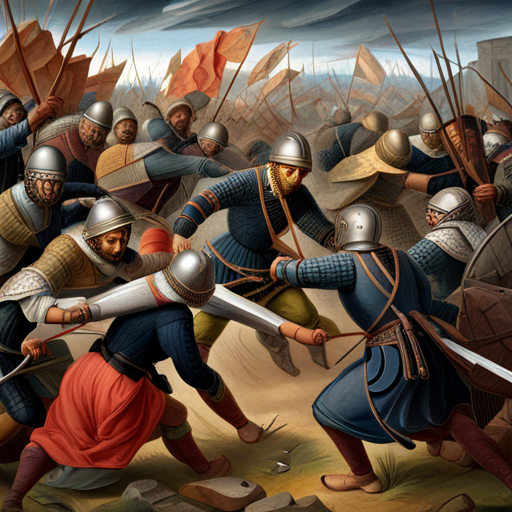

INFO:stability_sdk.client:Sending request.


{'start': 30.463, 'duration': 3.737, 'text': "O'er the ramparts we watched,", 'description': 'People watching from the ramparts of a fortress, with a sense of anticipation.'}
Generating image for People watching from the ramparts of a fortress, with a sense of anticipation.


INFO:stability_sdk.client:Got answer 607e30f9-aeca-4285-b842-17a626f6764e with artifact types ['ARTIFACT_IMAGE', 'ARTIFACT_CLASSIFICATIONS', 'ARTIFACT_LATENT'] in 2.40s


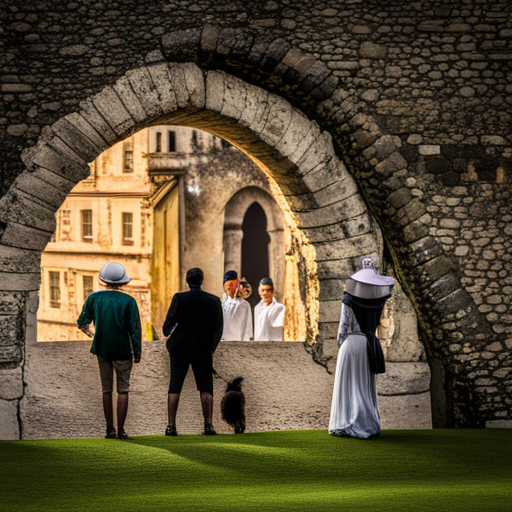

INFO:stability_sdk.client:Sending request.


{'start': 34.2, 'duration': 4.071, 'text': 'were so gallantly streaming?', 'description': 'The American flag streaming gallantly in the wind.'}
Generating image for The American flag streaming gallantly in the wind.


INFO:stability_sdk.client:Got answer 74692243-f1ab-4536-969a-a06c1c091317 with artifact types ['ARTIFACT_IMAGE', 'ARTIFACT_CLASSIFICATIONS', 'ARTIFACT_LATENT'] in 5.57s


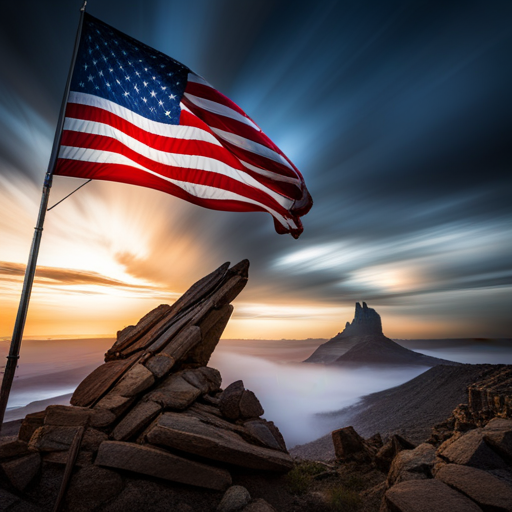

INFO:stability_sdk.client:Sending request.


{'start': 38.271, 'duration': 3.837, 'text': 'And the rockets red glare,', 'description': 'Rockets lighting up the sky with a red glare.'}
Generating image for Rockets lighting up the sky with a red glare.


INFO:stability_sdk.client:Got answer 9a4b2436-1aa6-4c13-a969-3dc558ecb9df with artifact types ['ARTIFACT_IMAGE', 'ARTIFACT_CLASSIFICATIONS', 'ARTIFACT_LATENT'] in 2.92s


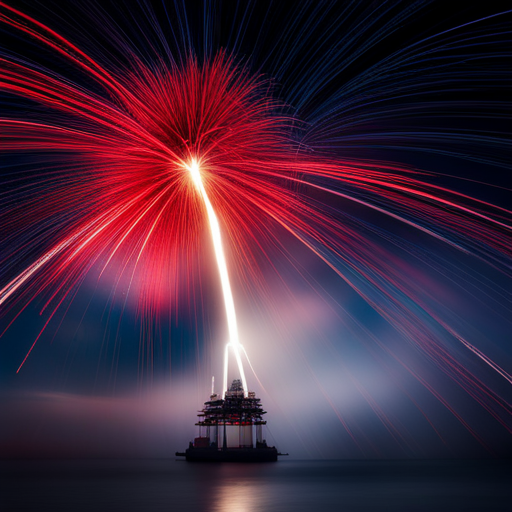

INFO:stability_sdk.client:Sending request.


{'start': 42.108, 'duration': 3.837, 'text': 'the bombs bursting in air,', 'description': 'Bombs exploding in the air, creating a dramatic scene.'}
Generating image for Bombs exploding in the air, creating a dramatic scene.


INFO:stability_sdk.client:Got answer 42947e06-aa6c-482d-b499-6f3a99bb9434 with artifact types ['ARTIFACT_IMAGE', 'ARTIFACT_CLASSIFICATIONS', 'ARTIFACT_LATENT'] in 2.86s


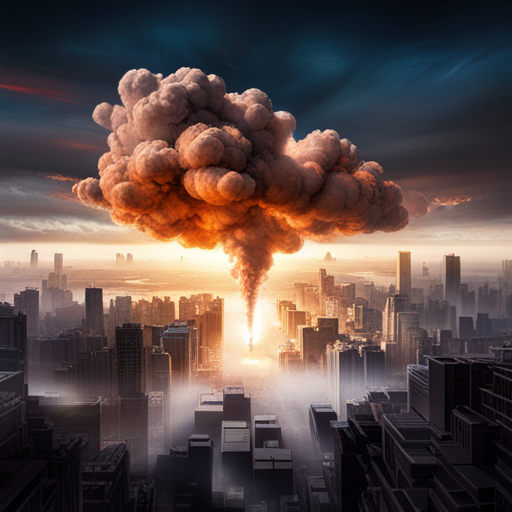

INFO:stability_sdk.client:Sending request.


{'start': 45.945, 'duration': 3.737, 'text': 'Gave proof through the night', 'description': 'A night sky, with the light from the bombs providing proof of the ongoing battle.'}
Generating image for A night sky, with the light from the bombs providing proof of the ongoing battle.


INFO:stability_sdk.client:Got answer 5ec775b3-78d6-4168-8931-55e46e3e3671 with artifact types ['ARTIFACT_IMAGE', 'ARTIFACT_CLASSIFICATIONS', 'ARTIFACT_LATENT'] in 2.55s


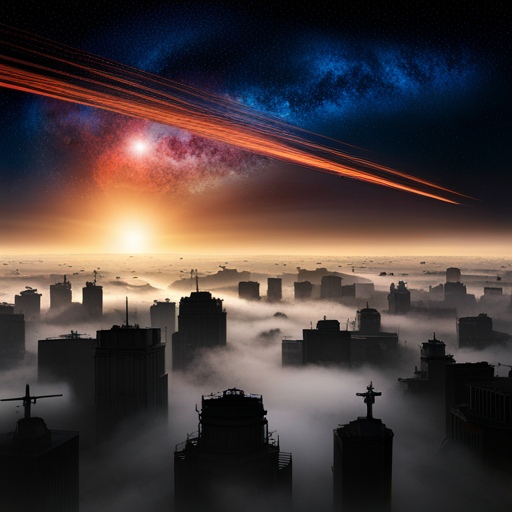

INFO:stability_sdk.client:Sending request.


{'start': 49.682, 'duration': 3.871, 'text': 'that our flag was still there.', 'description': 'The American flag still standing amidst the chaos of the battle.'}
Generating image for The American flag still standing amidst the chaos of the battle.


INFO:stability_sdk.client:Got answer 5e46a1b2-e6a0-4e41-b155-cc8397ec8457 with artifact types ['ARTIFACT_IMAGE', 'ARTIFACT_CLASSIFICATIONS', 'ARTIFACT_LATENT'] in 3.47s


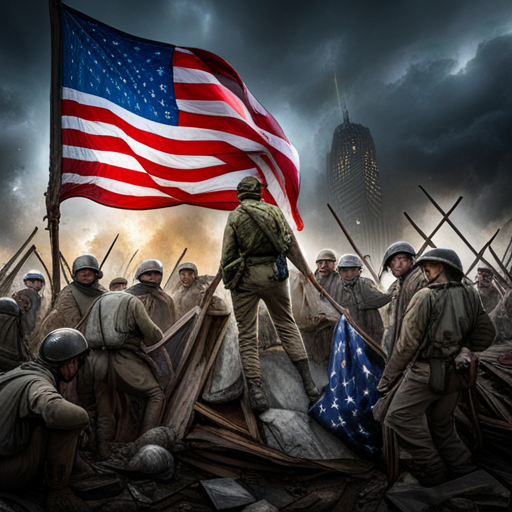

INFO:stability_sdk.client:Sending request.


{'start': 53.553, 'duration': 2.603, 'text': 'O say does that', 'description': 'A person asking a question, with a hopeful expression on their face.'}
Generating image for A person asking a question, with a hopeful expression on their face.


INFO:stability_sdk.client:Got answer d8de0666-3022-4a68-b4ec-7b2485be4489 with artifact types ['ARTIFACT_IMAGE', 'ARTIFACT_CLASSIFICATIONS', 'ARTIFACT_LATENT'] in 2.67s


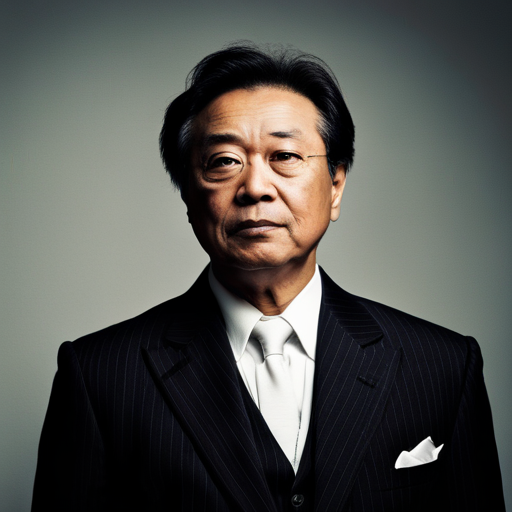

INFO:stability_sdk.client:Sending request.


{'start': 56.156, 'duration': 6.573, 'text': 'star spangled banner yet wave', 'description': 'The American flag, with its stars and stripes, waving in the wind.'}
Generating image for The American flag, with its stars and stripes, waving in the wind.


INFO:stability_sdk.client:Got answer f12fa8e7-4a09-45b3-9ffd-ef6ff8571581 with artifact types ['ARTIFACT_IMAGE', 'ARTIFACT_CLASSIFICATIONS', 'ARTIFACT_LATENT'] in 3.42s


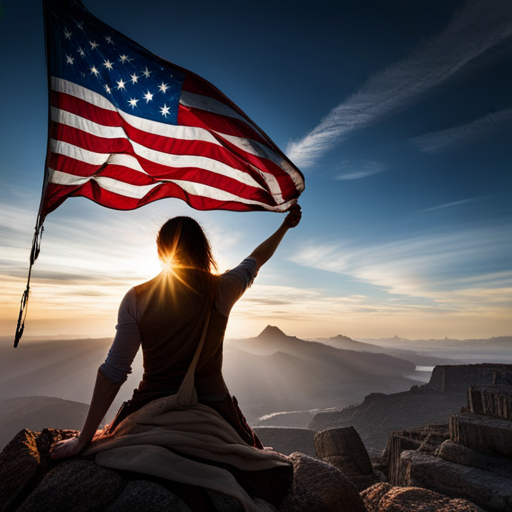

INFO:stability_sdk.client:Sending request.


{'start': 62.729, 'duration': 4.871, 'text': "O'er the land of the free,", 'description': 'A wide view of the American landscape, symbolizing freedom.'}
Generating image for A wide view of the American landscape, symbolizing freedom.


INFO:stability_sdk.client:Got answer 7355ace4-8350-4ff9-8a44-edd42b27e328 with artifact types ['ARTIFACT_IMAGE', 'ARTIFACT_CLASSIFICATIONS', 'ARTIFACT_LATENT'] in 2.84s


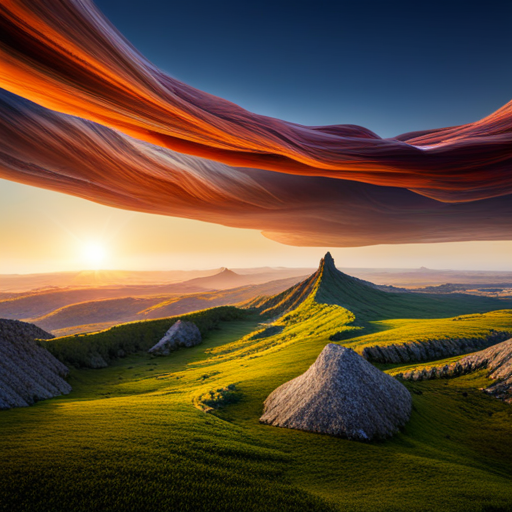

INFO:stability_sdk.client:Sending request.


{'start': 67.6, 'duration': 7.608, 'text': 'and the home of the brave.', 'description': 'A depiction of a peaceful home, representing bravery and resilience.'}
Generating image for A depiction of a peaceful home, representing bravery and resilience.


INFO:stability_sdk.client:Got answer 0bab47df-b6f9-4d62-aeb4-5e138ddbc4e5 with artifact types ['ARTIFACT_IMAGE', 'ARTIFACT_CLASSIFICATIONS', 'ARTIFACT_LATENT'] in 3.11s


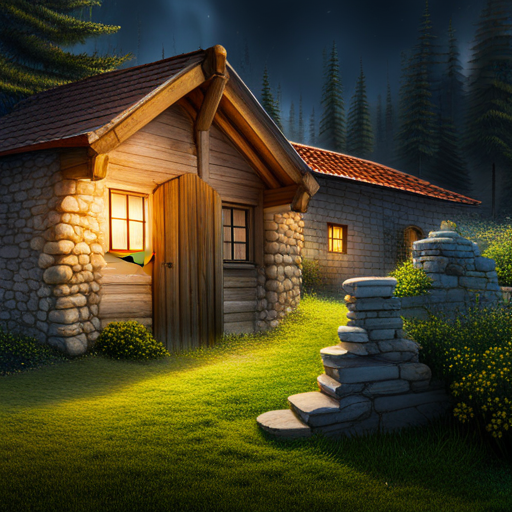

In [117]:
with open(image_description_file_path, 'r') as csv_file:
  reader = csv.DictReader(csv_file, quoting=csv.QUOTE_NONNUMERIC)
  for row in reader:
    print(row)
    description = row['description']
    filename = re.sub(r'[^\w\d-]','_', description).lower()
    image_file_path = os.path.join(out_dir, filename + '.png')
    if os.path.exists(image_file_path):
      print(f"Skipping description that has an image: {filename}")
    else:
      print(f"Generating image for {description}")
      image = generate_image(description)
      display(image)
      image.save(image_file_path)
